In [ ]:
#@title Loading Zenodo data and MAHLER
#@markdown First, install MAHLER from GitHub, and load trajectories from Zenodo.
#@markdown The simulation data is roughly 1.0 GB.
! pip install zenodo_get git+https://github.com/tiwarylab/mahler.git
! zenodo_get 17886490
! mkdir -p traj colvar
! mv *.xtc traj
! mv *.dat colvar

In [ ]:
#@title Reweighting
#@markdown This cell runs the reweighting. For 13 mutants, this cell should take ~50 minutes on a A100 runtime.

#@markdown The python call (not recommended) is mostly equivalent to this CLI command (recommended):
#@markdown ``` python
#@markdown mahler reweight -t traj -c colvar -f sequences.fasta -o output -s protein.pdb
#@markdown ```

from mahler.commands.reweight import execute

execute("traj", "colvar", "sequences.fasta", "output", topology_file="protein.pdb")

Pearson 0.654; Spearman 0.615


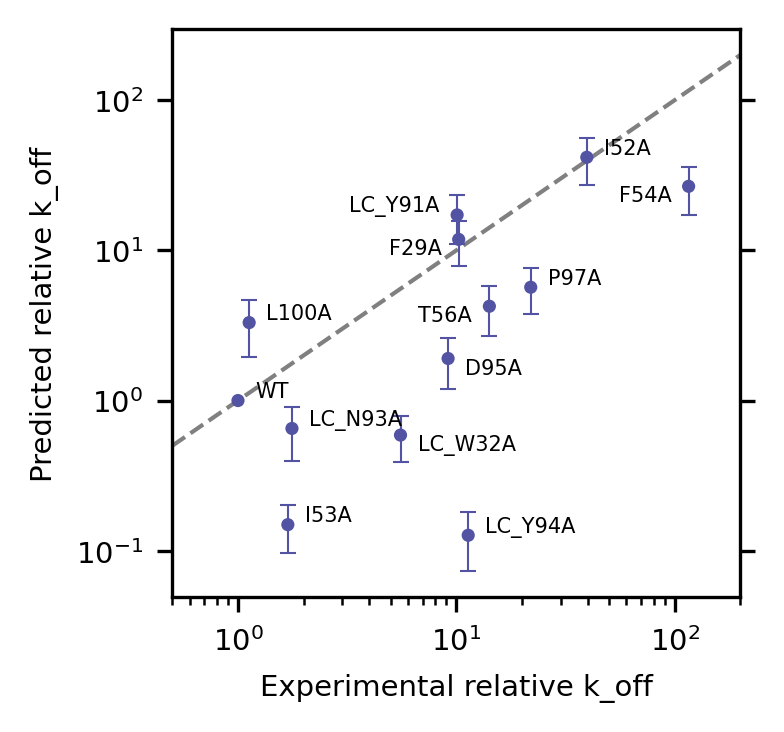

In [15]:
#@title Plotting

import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

literature_data = {
    'WT': 0.00012,
    'L100A': 0.000135,
    'I53A': 0.000203,
    'LC_N93A': 0.000212,
    'LC_W32A': 0.000666,
    'T56A': 0.0017,
    'LC_Y91A': 0.00121,
    'F29A': 0.00123,
    'D95A': 0.0011,
    'LC_Y94A': 0.00136,
    'P97A': 0.00263,
    'I52A': 0.00475,
    'F54A': 0.0139
  }

# load literature data
with open("output/poisson_fit.json") as f:
  dat = json.load(f)

# compute relative k_off
keys = list(literature_data.keys())
x = [literature_data[k]/literature_data["WT"] for k in keys]

mean = np.array([np.mean(dat[k]) for k in keys])
std = np.array([np.std(dat[k]) for k in keys])
wt = keys.index("WT")

wt_time = mean[wt]
y = wt_time / mean
yerr = np.sqrt((std / mean) ** 2 + (std[wt] / mean[wt]) ** 2) * y

# correlation
pearson_r, _ = pearsonr(x, y)
spearman_r, _ = spearmanr(x, y)
print(f"Pearson {pearson_r:.3f}; Spearman {spearman_r:.3f}")

# plotting
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300, constrained_layout=True)
ax.set_box_aspect(1)
ax.loglog()
color = "#5254a3"

# --------- fitting to line ------------
x_fit = np.linspace(0.5, 200, 100)
y_fit = x_fit

# print("95% CI:", bs_spearman(x, y))

# --------- plotting ------------
ax.plot(x_fit, y_fit, color="gray", linestyle="--", linewidth=1, zorder=0)
#ax.set_ylim(0.05, 10000)
ax.set_xlim(0.5, 200)
ax.tick_params(labelsize=7)
ax.yaxis.minorticks_off()
ax.tick_params(axis='y', labelleft=True,  left=True, right=True)
ax.scatter(x, y, c=color, s=10, edgecolors="none")

# ---------- errorbar ---------
for xx, yy, ee in zip(x, y, yerr):
    if np.isclose(xx, 1.0):
        continue
    ax.errorbar(xx, yy, yerr=ee, c=color, fmt="none", markersize=3, capsize=2, elinewidth=0.5, markeredgewidth=0.5)

# --------- reference line and text ---------
text_kwargs = {
    "fontsize": 5,
    "va": "center",
    "color": "k"
}
for xx, yy, ll in zip(x, y, keys):
    if ll in ["F54A", "T56A", "F29A"]: # bot-left
        ax.text(xx/1.2, yy/1.15, ll, ha="right", **text_kwargs)
    elif ll in ["LC_Y91A"]: # top-left
        ax.text(xx/1.2, yy*1.15, ll, ha="right", **text_kwargs)
    elif ll in ["LC_W32A", "D95A"]: # bot-right
        ax.text(xx*1.2, yy/1.15, ll, ha="left", **text_kwargs)
    else: # top-right
        ax.text(xx*1.2, yy*1.15, ll, ha="left", **text_kwargs)

ax.set_xlabel("Experimental relative k_off", fontsize=7)
ax.set_ylabel("Predicted relative k_off", fontsize=7)

fig.savefig("figure2c.pdf", bbox_inches="tight")
